In [1]:
# / \file
# / \ingroup tutorial_tmva
# / \notebook
# /  TMVA Classification Example Using a Convolutional Neural Network
# /
# / This is an example of using a CNN in TMVA. We do classification using a toy image data set
# / that is generated when running the example macro
# /
# / \macro_image
# / \macro_output
# / \macro_code
# /
# / \author Neel Shah


 # TMVA Classification Example Using a Convolutional Neural Network


#  Helper function to create input images data
#  we create a signal and background 2D histograms from 2d gaussians
#  with a location (means in X and Y)  different for each event
#  The difference between signal and background is in the gaussian width.
#  The width for the background gaussian is slightly larger than the signal width by few % values
# 
# 

In [2]:
import ROOT
from ROOT import TMVA 
import os
from array import array

Welcome to JupyROOT 6.26/00


In [3]:
ROOT.TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

## For PYMVA methods
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("CNN_ClassificationOutput.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_CNN_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )


In [4]:
opt=[1,1,1,1,1]
useTMVACNN = opt[0] if (len(opt) > 0) else False
useKerasCNN = opt[0] if (len(opt) > 1) else False
useTMVADNN = opt[0] if (len(opt) > 2) else False
useTMVABDT = opt[0] if (len(opt) > 3) else False
usePyTorchCNN = opt[0] if (len(opt) > 4) else False
# useTMVACNN = False

writeOutputFile = True

num_threads = 0  # use default threads



## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

ROOT.TMVA.Tools.Instance()


In [5]:
# do enable MT running
if (num_threads >= 0):
  ROOT.EnableImplicitMT(num_threads)
  if (num_threads > 0):
     ROOT.gSystem.Setenv("OMP_NUM_THREADS", ROOT.TString.Format("%d",num_threads))

else:
  ROOT.gSystem.Setenv("OMP_NUM_THREADS", "1")

print("Running with nthreads  = " + str(ROOT.GetThreadPoolSize()) )

Running with nthreads  = 4


In [6]:
if __debug__:
    ROOT.gSystem.Setenv("KERAS_BACKEND", "tensorflow")
    # for using Keras
#     TMVA.PyMethodBase.PyInitialize()
else:
    useKerasCNN = False

In [7]:
# if (writeOutputFile):
#     outputFile = ROOT.TFile.Open("TMVA_CNN_ClassificationOutput.root", "RECREATE")


In [9]:
'''
      
    ## Create TMVA Factory
    Create the Factory class. Later you can choose the methods
    whose performance you'd like to investigate.

    The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

    - The first argument is the base of the name of all the output
    weightfiles in the directory weight/ that will be created with the
    method parameters

    - The second argument is the output file for the training results

    - The third argument is a string option defining some general configuration for the TMVA session.
      For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the
   option string

    - note that we disable any pre-transformation of the input variables and we avoid computing correlations between
   input variables
'''

factory =  ROOT.TMVA.Factory (
  "TMVA_CNN_Classification", outputFile,
  "!V:ROC:!Silent:Color:AnalysisType=Classification:Transformations=None:!Correlations")


In [10]:
'''

  ## Declare DataLoader(s)

  The next step is to declare the DataLoader class that deals with input variables

  Define the input variables that shall be used for the MVA training
  note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

  In this case the input data consists of an image of 16x16 pixels. Each single pixel is a branch in a ROOT TTree

'''
loader = ROOT.TMVA.DataLoader("dataset")

In [11]:
'''

   ## Setup Dataset(s)

   Define input data file and signal and background trees

'''

imgSize = 16 * 16
inputFileName = "images_data_16x16.root"
inputFile = ROOT.TFile.Open(inputFileName)
if (inputFile == None):
    Error("TMVA_CNN_Classification", "Error opening input file %s - exit", inputFileName.Data())
signalTree     = inputFile.Get("sig_tree")
backgroundTree = inputFile.Get("bkg_tree")

signalTree.Print()


******************************************************************************
*Tree    :sig_tree  : signal_tree                                            *
*Entries :     5000 : Total =         5207924 bytes  File  Size =    4659345 *
*        :          : Tree compression factor =   1.12                       *
******************************************************************************
*Br    0 :vars      : vector<float>                                          *
*Entries :     5000 : Total  Size=    5207506 bytes  File Size  =    4657486 *
*Baskets :      167 : Basket Size=      32000 bytes  Compression=   1.12     *
*............................................................................*


In [12]:
# inputFile = ROOT.TFile.Open(inputFileName)
# if (inputFile == None):
#     Error("TMVA_CNN_Classification", "Error opening input file %s - exit", inputFileName.Data())
# signalTree = inputFile.Get("sig_tree")
# backgroundTree = inputFile.Get("bkg_tree")

# signalTree.Print()

nEventsSig = signalTree.GetEntries()
nEventsBkg = backgroundTree.GetEntries()
# global event weights per tree (see below for setting event-wise weights)
signalWeight = 1.0
backgroundWeight = 1.0

# You can add an arbitrary number of signal or background trees
loader.AddSignalTree(signalTree, signalWeight)
loader.AddBackgroundTree(backgroundTree, backgroundWeight)

## add event variables (image)
## use new method (from ROOT 6.20 to add a variable array for all image data)
 

loader.AddVariablesArray("vars",imgSize,'F')

# Set individual event weights (the variables must exist in the original TTree)
#    for signal    : factory.SetSignalWeightExpression    ("weight1*weight2")
#    for background: factory.SetBackgroundWeightExpression("weight1*weight2")
# loader.SetBackgroundWeightExpression( "weight" )

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 5000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 5000 events


In [13]:
# Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("") # for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("") # for example: TCut mycutb = "abs(var1)<0.5";

#  Tell the factory how to use the training and testing events
# 
#  If no numbers of events are given, half of the events in the tree are used
#  for training, and the other half for testing:
#     loader->PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" );
#  It is possible also to specify the number of training and testing events,
#  note we disable the computation of the correlation matrix of the input variables

nTrainSig = 0.8 * nEventsSig
nTrainBkg = 0.8 * nEventsBkg

#  build the string options for DataLoader::PrepareTrainingAndTestTree
prepareOptions = "nTrain_Signal="+str(nTrainSig)+":nTrain_Background="+str(nTrainBkg)+":SplitMode=Random:SplitSeed=100:NormMode=NumEvents:!V:!CalcCorrelations"
  

loader.PrepareTrainingAndTestTree(mycuts, mycutb, prepareOptions)

'''

   DataSetInfo              : [dataset] : Added class "Signal"
   : Add Tree sig_tree of type Signal with 10000 events
   DataSetInfo              : [dataset] : Added class "Background"
   : Add Tree bkg_tree of type Background with 10000 events



'''

# signalTree.Print();


'\n\n   DataSetInfo              : [dataset] : Added class "Signal"\n   : Add Tree sig_tree of type Signal with 10000 events\n   DataSetInfo              : [dataset] : Added class "Background"\n   : Add Tree bkg_tree of type Background with 10000 events\n\n\n\n'

In [14]:
'''
    # Booking Methods

    Here we book the TMVA methods. We book a Boosted Decision Tree method (BDT)

'''

# Boosted Decision Trees
# if (useTMVABDT):
#   factory.BookMethod(loader, ROOT.TMVA.Types.kBDT, "BDT","!V:NTrees=400:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:"+"UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20")

'''
#### Booking Deep Neural Network

Here we book the DNN of TMVA. See the example TMVA_Higgs_Classification.C for a detailed description of the
options
'''

if (useTMVADNN):
  layoutString = "Layout=DENSE|100|RELU,BNORM,DENSE|100|RELU,BNORM,DENSE|100|RELU,BNORM,DENSE|100|RELU,DENSE|1|LINEAR"

  #  Training strategies
  #  one can catenate several training strings with different parameters (e.g. learning rates or regularizations
  #  parameters) The training string must be concatenates with the `|` delimiter
  trainingString1 = "LearningRate=1e-3,Momentum=0.9,Repetitions=1,"+ "ConvergenceSteps=5,BatchSize=100,TestRepetitions=1,"+"MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"+"Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0."
                          

  trainingStrategyString = "TrainingStrategy="
  trainingStrategyString += trainingString1 # + "|" + trainingString2 + ....

  # Build now the full DNN Option string

  dnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:"+"WeightInitialization=XAVIER"
  dnnOptions+= ":"
  dnnOptions+= layoutString
  dnnOptions+= ":"
  dnnOptions+= trainingStrategyString

  dnnMethodName = "TMVA_DNN_CPU"

  dnnOptions += ":Architecture=CPU"


factory.BookMethod(loader, ROOT.TMVA.Types.kDL, dnnMethodName, dnnOptions)

Factory                  : Booking method: TMVA_DNN_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIER:Layout=DENSE|100|RELU,BNORM,DENSE|100|RELU,BNORM,DENSE|100|RELU,BNORM,DENSE|100|RELU,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=5,BatchSize=100,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIER:Layou

In [15]:
'''
### Book Convolutional Neural Network in TMVA

For building a CNN one needs to define

-  Input Layout :  number of channels (in this case = 1)  | image height | image width
-  Batch Layout :  batch size | number of channels | image size = (height*width)

Then one add Convolutional layers and MaxPool layers.

-  For Convolutional layer the option string has to be:
   - CONV | number of units | filter height | filter width | stride height | stride width | padding height | paddig
width | activation function

   - note in this case we are using a filer 3x3 and padding=1 and stride=1 so we get the output dimension of the
conv layer equal to the input

  - note we use after the first convolutional layer a batch normalization layer. This seems to help significantly the
convergence

 - For the MaxPool layer:
    - MAXPOOL  | pool height | pool width | stride height | stride width

The RESHAPE layer is needed to flatten the output before the Dense layer


Note that to run the CNN is required to have CPU  or GPU support

'''



inputLayoutString ="InputLayout=1|16|16"

#  Batch Layout
layoutString = "Layout=CONV|10|3|3|1|1|1|1|RELU,BNORM,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,"+"RESHAPE|FLAT,DENSE|100|RELU,DENSE|1|LINEAR"

#  Training strategies.
trainingString1 = "LearningRate=1e-3,Momentum=0.9,Repetitions=1,"+"ConvergenceSteps=5,BatchSize=100,TestRepetitions=1,"+"MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"+"Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0"

trainingStrategyString = "TrainingStrategy="
trainingStrategyString += trainingString1 # + "|" + trainingString2 + "|" + trainingString3; for concatenating more training strings

# Build full CNN Options.


cnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:" +"WeightInitialization=XAVIER::Architecture=CPU"

cnnOptions +=  ":" + inputLayoutString
cnnOptions +=  ":" + layoutString
cnnOptions +=  ":" + trainingStrategyString
  ## New DL (CNN)
cnnMethodName = "TMVA_CNN_CPU"
# use GPU if available


cnnOptions += ":Architecture=CPU"
cnnMethodName = "TMVA_CNN_CPU"


factory.BookMethod(loader, ROOT.TMVA.Types.kDL, cnnMethodName, cnnOptions)


Factory                  : Booking method: TMVA_CNN_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=None:WeightInitialization=XAVIER::Architecture=CPU:InputLayout=1|16|16:Layout=CONV|10|3|3|1|1|1|1|RELU,BNORM,CONV|10|3|3|1|1|1|1|RELU,MAXPOOL|2|2|1|1,RESHAPE|FLAT,DENSE|100|RELU,DENSE|1|LINEAR:TrainingStrategy=LearningRate=1e-3,Momentum=0.9,Repetitions=1,ConvergenceSteps=5,BatchSize=100,TestRepetitions=1,MaxEpochs=20,WeightDecay=1e-4,Regularization=None,Optimizer=ADAM,DropConfig=0.0+0.0+0.0+0.0:Architecture=CPU"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CRO

In [16]:


ROOT.Info("TMVA_CNN_Classification", "Building convolutional keras model")
#  create python script which can be executed
#  create 2 conv2d layer + maxpool + dense

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape, BatchNormalization

model = Sequential()
model.add(Reshape((16, 16, 1), input_shape = (256, )))
model.add(Conv2D(10, kernel_size=(3,3), kernel_initializer='TruncatedNormal', activation='relu', padding='same' ) )
model.add(Conv2D(10, kernel_size=(3,3), kernel_initializer='glorot_normal', activation ='relu', padding = 'same') )
model.add(BatchNormalization())
model.add(Conv2D(10, kernel_size = (3,3), kernel_initializer = 'glorot_normal',activation ='relu', padding = 'same') )
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (1,1))) 
model.add(Flatten())
model.add(Dense(256, activation = 'relu')) 
model.add(Dense(2, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
model.save('model_cnn.h5')
model.summary()



if (ROOT.gSystem.AccessPathName("model_cnn.h5")):
 Warning("TMVA_CNN_Classification", "Error creating Keras model file - skip using Keras")
else:
 #  book PyKeras method only if Keras model could be created
 ROOT.Info("TMVA_CNN_Classification", "Booking tf.Keras CNN model")


factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, "PyKeras","H:!V:VarTransform=None:FilenameModel=model_cnn.h5:"+"FilenameTrainedModel=trained_model_cnn.h5:NumEpochs=20:BatchSize=128")


      

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 10)        100       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 10)        910       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 10)       40        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 10)        910       
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 10)       40        
 hNormalization)                                        

Factory                  : Booking method: PyKeras
                         : 
                         : Setting up keras with tensorflow backend
                         : Using Keras version 2.8
                         : Using TensorFlow version 2
<WARNING>                : The Keras version is not compatible with TensorFlow 2. Use instead tf.keras
                         : Use Keras version from TensorFlow : tf.keras
                         :  Loading Keras Model 
                         : Loaded model from file: model_cnn.h5


Info in <TMVA_CNN_Classification>: Building convolutional keras model
2022-03-29 03:41:47.554821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/neel/Root/install/lib:/opt/ros/noetic/lib
2022-03-29 03:41:47.554847: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-29 03:41:49.098520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/neel/Root/install/lib:/opt/ros/noetic/lib
2022-03-29 03:41:49.098545: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-29 03:41:49.098565: I tensorflow/stream_executor/cuda/cud

In [17]:
# import torch
# from torch import nn
# # from .modules import *  # noqa: F403
# # from .parameter import Parameter, UninitializedParameter, UninitializedBuffer
# # from .parallel import DataParallel
# if (usePyTorchCNN):

#   ROOT.Info("TMVA_CNN_Classification", "Using Convolutional PyTorch Model")
#   pyTorchFileName = str(ROOT.gROOT.GetTutorialDir()) + "/tmva/PyTorch_Generate_CNN_Model.py"
#   print(pyTorchFileName)
#   # check that pytorch can be imported and file defining the model and used later when booking the method is existing
#   if (ROOT.gSystem.Exec("python -c 'import torch'")  | ROOT.gSystem.AccessPathName(pyTorchFileName) ):
#      Warning("TMVA_CNN_Classification", "PyTorch is not installed or model building file is not existing - skip using PyTorch")
#   else:
#      # book PyTorch method only if PyTorch model could be created
#      ROOT.Info("TMVA_CNN_Classification", "Booking PyTorch CNN model")
#      methodOpt = "H:!V:VarTransform=None:FilenameModel=PyTorchModelCNN.pt:" + "FilenameTrainedModel=PyTorchTrainedModelCNN.pt:NumEpochs=20:BatchSize=100"
#      methodOpt += ":UserCode=" + pyTorchFileName
#      factory.BookMethod(loader, ROOT.TMVA.Types.kPyTorch, "PyTorch", methodOpt)

In [18]:
#  ## Train Methods

factory.TrainAllMethods()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 10)        100       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 10)        910       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 10)       40        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 10)        910       
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 10)       40        
 hNormalization)                                        

In [19]:
## Test and Evaluate Methods

factory.TestAllMethods();

factory.EvaluateAllMethods();




Factory                  : Test all methods
Factory                  : Test method: TMVA_DNN_CPU for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
TMVA_DNN_CPU             : [dataset] : Evaluation of TMVA_DNN_CPU on testing sample (2000 events)
                         : Elapsed time for evaluation of 2000 events: 0.0126 sec       
Factory                  : Test method: TMVA_CNN_CPU for Classification performance
                         : 
                         : Evaluate deep neural network on CPU using batches with size = 1000
                         : 
TMVA_CNN_CPU             : [dataset] : Evaluation of TMVA_CNN_CPU on testing sample (2000 events)
                         : Elapsed time for evaluation of 2000 events: 0.504 sec       
Factory                  : Test method: PyKeras for Classification performance
                         : 
        

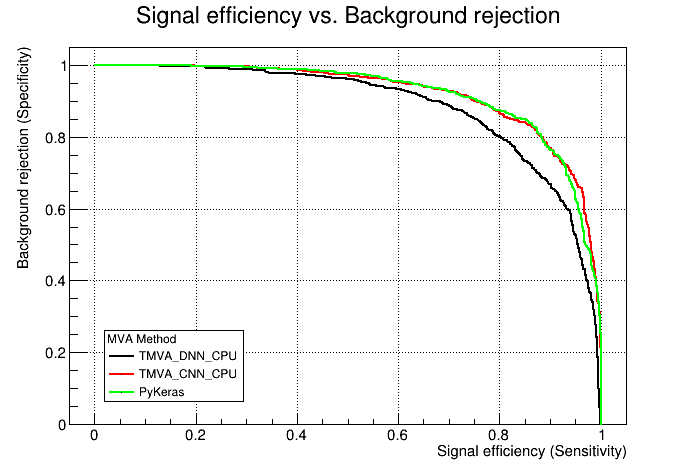

In [20]:
## Plot ROC Curve

c1 = factory.GetROCCurve(loader);
c1.Draw();



In [21]:
# close outputfile to save output file
outputFile.Close();


